In [1]:
import numpy as np
import gwsurrogate
import matplotlib.pyplot as plt
%matplotlib inline
from pycbc.types import TimeSeries

/opt/anaconda3/envs/ringdown/lib/python3.10/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/opt/anaconda3/envs/ringdown/lib/python3.10/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
# This can take a few minutes
gwsurrogate.catalog.pull('NRHybSur3dq8')

'/opt/anaconda3/envs/ringdown/lib/python3.10/site-packages/gwsurrogate/surrogate_downloadsNRHybSur3dq8.h5'

In [3]:
sur = gwsurrogate.LoadSurrogate('NRHybSur3dq8')
type(sur)

Loaded NRHybSur3dq8 model


gwsurrogate.surrogate.NRHybSur3dq8

In [4]:
q = 1
chiA = [0, 0, 0]
chiB = [0, 0, 0]
f_low = 0  # this will be ignored and the wavefrom will be returned on the times given below
times = np.arange(-10000,130,0.1)
# The returned times are the same as the input times
times, h, dyn = sur(q, chiA, chiB, times=times, f_low=f_low)
print(h[(2,2)])

[7.85207906e-02+0.00000000e+00j 7.85207497e-02-1.87547729e-04j
 7.85202609e-02-3.75095937e-04j ... 1.49585322e-05-1.48971767e-05j
 1.26867753e-05-1.55188599e-05j 1.04385665e-05-1.58564611e-05j]


In [5]:
def wrap_surrogate_to_pycbc(
    sur,
    mass_1,
    mass_2,
    spin_1x,
    spin_1y,
    spin_1z,
    spin_2x,
    spin_2y,
    spin_2z,
    luminosity_distance=1,
    incl=None,
    phi=None,
    f_low=None,
    dt=None,
    mode_list=None):
    """
    sur ::gwsurrogate.surrogate object
        The surrogate to use, as loaded from gwsurrogate.LoadSurrogate()
    mass_1 ::float
        The mass of the primary in MSun
    mass_2 ::float
        The mass of the secondary in MSun
    spin_1x ::float
        The dimensionless spin component in the x direction of the primary
    spin_1y ::float
        The dimensionless spin component in the y direction of the primary
    spin_1z ::float
        The dimensionless spin component in the z direction of the primary
    spin_2x ::float
        The dimensionless spin component in the x direction of the secondary
    spin_2y ::float
        The dimensionless spin component in the y direction of the secondary
    spin_2z ::float
        The dimensionless spin component in the z direction of the secondary
    luminosity_distance ::float
        The luminosity distance to the system in Mpc, defaults to 1
    incl ::float
        The inclination of the system - if not passed then modes will remain uncombined
    phi ::float
        The reference phase of the system - must be passed with incl to combine modes
    f_low ::float
        The lower frequency in Hz at which to generate the waveform
    dt ::float 
        The sampling rate for the waveform, should generally be 1 / 2^n for some n (e.g. 1 / 4096)
    mode_list ::list
        A list of modes, each a tuple (l,m) to generate the waveform with
    """
    # NR Convention
    q = mass_1 / mass_2
    chi1 = [spin_1x, spin_1y, spin_1z]
    chi2 = [spin_2x, spin_2y, spin_2z]
    total_mass = mass_1 + mass_2
    
    if (incl is None) != (phi is None):
        raise ValueError(
            "Either both of incl and phi should be specified, or neither should be"
        )
    
    times, h, _ = sur(
        q,
        chi1,
        chi2,
        M=total_mass,
        f_low=f_low,
        dt=dt,
        mode_list = mode_list,
        inclination=incl,
        phi_ref=phi,
        dist_mpc=luminosity_distance,
        units='mks'
    )
    
    if incl is not None:
        hp = TimeSeries(np.real(h), delta_t=dt)
        hc = TimeSeries(-np.imag(h), delta_t=dt)
        
    else:
        hp = dict()
        hc = dict()
        for mode, hlm in h.items():
            hp[mode] = TimeSeries(np.real(h[mode]), delta_t=dt)
            hc[mode] = TimeSeries(-np.imag(h[mode]), delta_t=dt)
    
    
    
    return hp, hc
    

In [18]:
hp_modes, hc_modes = wrap_surrogate_to_pycbc(sur, 35, 29, 0, 0, 0.65, 0, 0, 0.75, f_low=20, dt=1 / 16384.)

(0.95, 0.97)

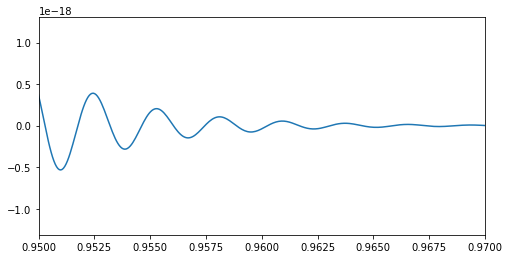

In [32]:
test_22 = hp_modes[(2,2)]
plt.figure(figsize=((8,4)))
plt.plot(test_22.sample_times, test_22)
plt.xlim(0.95,0.97)